## A quick-start guide on using `fqlag` package

`fqlag` is written in pure python. The base calculations are implemented using `numpy`'s vectorizations, the matrix inversion, which is typically the slowest part of calculating the likelihood function uses numpy/scipy which run in multiple cpu's by default.

This documents gives a simple example of calculating the periodogram and delays from simulated light curves, found in `data.lc`.

Other usage examples can be found in the `test.py` file in the main repository directory.

Individual functions and classes have some documentations too.


### Import the relevant packages

In [ ]:
# Install fqlag if not already installed
!pip install fqlag

In [1]:
import numpy as np
import fqlag
import matplotlib.pyplot as plt

# change some settings in the plot to make them clear
plt.rcParams.update({
    'font.size': 16, 
    'font.family': 'monospace'
})

Uncomment the following if you want to use new simulated light curves. The following uses the code in `test.py`, which relies on [`aztools`](https://github.com/zoghbi-a/aztools).

The Following tutorial uses simlated light curves in `data.lc`
The file has two light curves (continuously-sampled), with the file having 5 columns: 

`time`, `rate_1`, `rateErr_1`, `rate_2`, `rateErr_2`

There is a phase delay of 1 radian between the two light curves.

In [2]:
# import sys
# import os
# sys.path.insert(0, '.')
# import test

# s = test.simulate_lc(1024, 1.0, 500, 1, bkp = [1e-4, -1, -2, 6e-3], phase=True)
# s = np.array(s[:-1])
# txt = '\n'.join([' '.join(['%4.4g'%s[j,i] for j in range(s.shape[0])]) for i in range(s.shape[1])])
# with open('data.lc', 'w') as fp: fp.write(txt)

### Read and plot the light curves

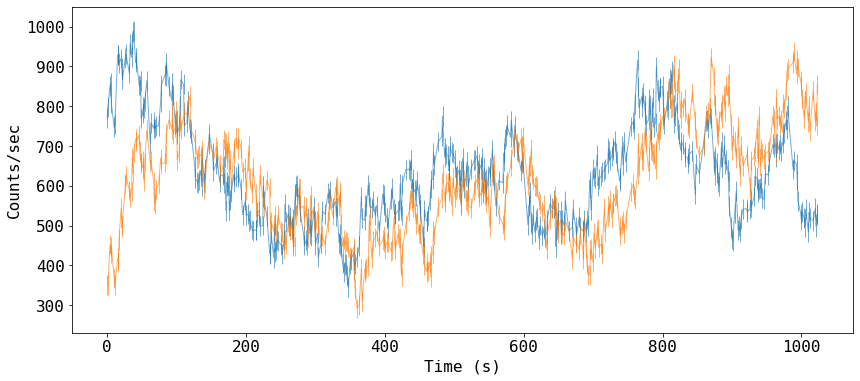

In [29]:
# read light curves
data_raw = np.loadtxt('data.lc')

# add some gaps #
np.random.seed(2334)
idx = np.arange(s.shape[1])
prob = np.cos(0.6*idx)**2
idxGap = np.sort(np.random.choice(idx, np.int(len(idx)/2), replace=False, p = prob/prob.sum()))
data = data_raw[idxGap, :]

fig = plt.figure(figsize=(14,6))
_ = plt.errorbar(data[:,0], data[:,1], data[:,2], fmt='-', ms=4, lw=1, alpha=0.6)
_ = plt.errorbar(data[:,0], data[:,3], data[:,4], fmt='-', ms=4, lw=1, alpha=0.6)
#_ = plt.plot(data[:,0], data[:,3])
plt.xlabel('Time (s)')
_ = plt.ylabel('Counts/sec')


### Prepare the data
- Let's split the light curve into two, and fit them simultaneously
- For modeling the power spectrum (PSD), we use: `fqlag.Psd(...)`, which takes as input arrays of `time`, `countRate` and `countRateError`, in addition to an array defining the frequency bin boundaries.
- The frequency bins need to incorporate all the frequencies available in the data from `fmin` to `fmax`, where `fmin=1/T`, with `T` bin the longest separation between points in the light curves, or `T = time[-1] - time[0]`, and `fmax = 1/(2*dt)`, where `dt` is the shortest separation, or `dt = min(time[1:] - time[:-1])`

In [4]:
# Split the light curve into segments #
isplit = data.shape[0]//2
timeArrays = [data[:isplit,0], data[isplit:,0]]
lc1Arrays  = [data[:isplit,1], data[isplit:,1]]
lc1Errors  = [data[:isplit,2], data[isplit:,2]]
lc2Arrays  = [data[:isplit,3], data[isplit:,3]]
lc2Errors  = [data[:isplit,4], data[isplit:,4]]

print(f'We have {len(timeArrays)} segments, with lengths ({len(timeArrays[0])}, {len(timeArrays[1])})')
print('\n', '-'*20)


# frequency bins
fmin = np.min([1./(timeArrays[0][-1] - timeArrays[0][0]), 
               1./(timeArrays[1][-1] - timeArrays[1][0])])
fmax = np.max([0.5/np.min(timeArrays[0][1:] - timeArrays[0][:-1]), 
               0.5/np.min(timeArrays[1][1:] - timeArrays[1][:-1])])
fqBins = np.logspace(np.log10(2*fmin), np.log10(0.5*fmax), 7)
fqBins = np.concatenate([[0.1*fqBins[0]], fqBins, [2*fqBins[-1]] ])
print('\nThe frequency bins are:', ' '.join(['%4.4g'%x for x in fqBins]))

We have 2 segments, with lengths (256, 256)

 --------------------

The frequency bins are: 0.0003899 0.003899 0.0078 0.0156 0.03122 0.06246 0.125 0.25  0.5




---
### Calculate the psd of the first light curve

For each light curve we have, we create a model using `fqlag.Psd(...)`, and then create a model that calculates the joints likelihood using: `fqlag.multiFqLagBin`

In a simple use, `fqlag.Psd(...)` takes three arrays as input: `time`, `countRate` and `countRateError`, plus the array defining frequency bins. We also, request that the model calculates the psd values in natural log units by passing `log=True`.

In [5]:
# create the models for individual light curves
psdMods = [fqlag.Psd(timeArrays[i], lc1Arrays[i], lc1Errors[i], fqBins, log=True) for i in range(2)]
#psdMods = [fqlag.Psd(data[:,0], data[:,1], data[:,2], fqBins, log=True)]

# merge the models that calculates the joints likelihood 
psdMod = fqlag.multiFqLagBin(psdMods)


They only thing left before starting the likelihood maximization is a starting array holding the input psd values at the chosen frequency bins, this should have a length `len(fqBins)-1`. 

We then print the log likelihood at these input values as a test that things are ok.



In [6]:
# initial parameters, start with ones
inPars = np.ones_like(fqBins[:-1])

# print the loglikelihood for the input values ##
logLike = psdMod.loglikelihood(inPars)

print('Input parameters: ', ' '.join(['%4.4g'%x for x in inPars]))
print('Corresponding Log-likelihood: %4.4g'%logLike)

Input parameters:     1    1    1    1    1    1    1    1
Corresponding Log-likelihood: -3856


---
### Maximizing the likelihood function

We now do the likelihood maximization using `fqlag.misc.maximize`, which uses the `BFGS` method from `scipy.optimize`.

It takes as arguments, the model we just defined, and the input array (plus other arguments to control the fit). 
This uses a quadratic approximation to the likelihood, and loops until a best fit value is found. The result is returned as a tuple of best fit values (`psd`), their ESTIMATED uncertainties (`psdErr`) taken from the hessian of the likelihood function and the fit obsject returned by `scipy.optimize.minimize`. The uncertainty estimates are generally a lower limit only. One needs to used either `fqlag.misc.errors` or `fqlag.misc.run_mcmc` to get full errors.

The progress is printed:

- Log-Likelihood | model-parameters | gmax: maximum absolute gradient at current location


In [9]:
# maximize the log-likelihood
psd, psdErr, psdFit = fqlag.misc.maximize(psdMod, inPars)

print('psd values:\t\t', '\t'.join(['%4.4g'%x for x in psd]))
print('psd uncertainties:\t', '\t'.join(['%4.4g'%x for x in psdErr]))
print('Maximum Likelihood:\t%4.4g'%(-psdFit.fun) )

   -2628.9 |       1.89    -0.0146      -1.01      -1.75      -3.71      -4.95      -6.55      -8.25 |    6.1e-05
** done **

psd values:		 1.886	-0.01464	-1.009	-1.751	-3.713	-4.946	-6.55	-8.247
psd uncertainties:	 0.479	0.6214	0.39	0.2573	0.2361	0.2572	0.6637	1.562
Maximum Likelihood:	-2629


Note that the last value in the psd is hardly constrained, and it is consistent with zero. i.e. no variability power. This is because this band is dominated by the noise in the light curves.

---
### Plot the results
We compare these estimates from the simple estimate from the square absolute of the Fourier transform of the raw light curve that we started with.

Note that the raw light curve is plotted without subtracting the poisson noise, which is manifested as a constant at high frequencies. Our model fitting gives values that are noise-subtracted.

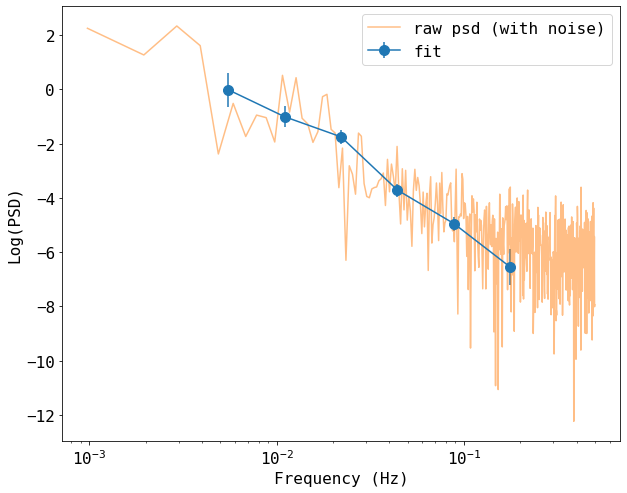

In [10]:
# calcualte the raw psd #
n = data_raw.shape[0]
freq_raw = np.fft.rfftfreq(n, 1.0)[1:-1]
psd_raw  = (2*1.0/(n*data_raw[:,1].mean()**2)) * np.abs(np.fft.rfft(data_raw[:,1])[1:-1])**2


# frequency from the geometric mean of our selected bins
freq = 10**(np.log10( (fqBins[:-1]*fqBins[1:]) )/2.)

plt.figure(figsize=(10,8))
plt.errorbar(freq[1:-1], psd[1:-1], yerr=psdErr[1:-1], fmt='-o', ms=10, label='fit')
plt.plot(freq_raw, np.log(psd_raw), label='raw psd (with noise)', alpha=0.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Log(PSD)')
plt.xscale('log')
plt.legend()

---
### Run MCMC chain to estimate the posterior distribution
This uses the `emcee` package, so it should be installed (e.g. `pip install emcee`)

The returned array has shape `(ntotal_runs, npar+1)`, where loglikelihood value is returned in the last element of the 2nd dimension.

In [20]:
chain = fqlag.misc.run_mcmc(psdMod, psd, psdErr, nwalkers=20, nrun=400)

acceptance fraction:  0.43000000000000005


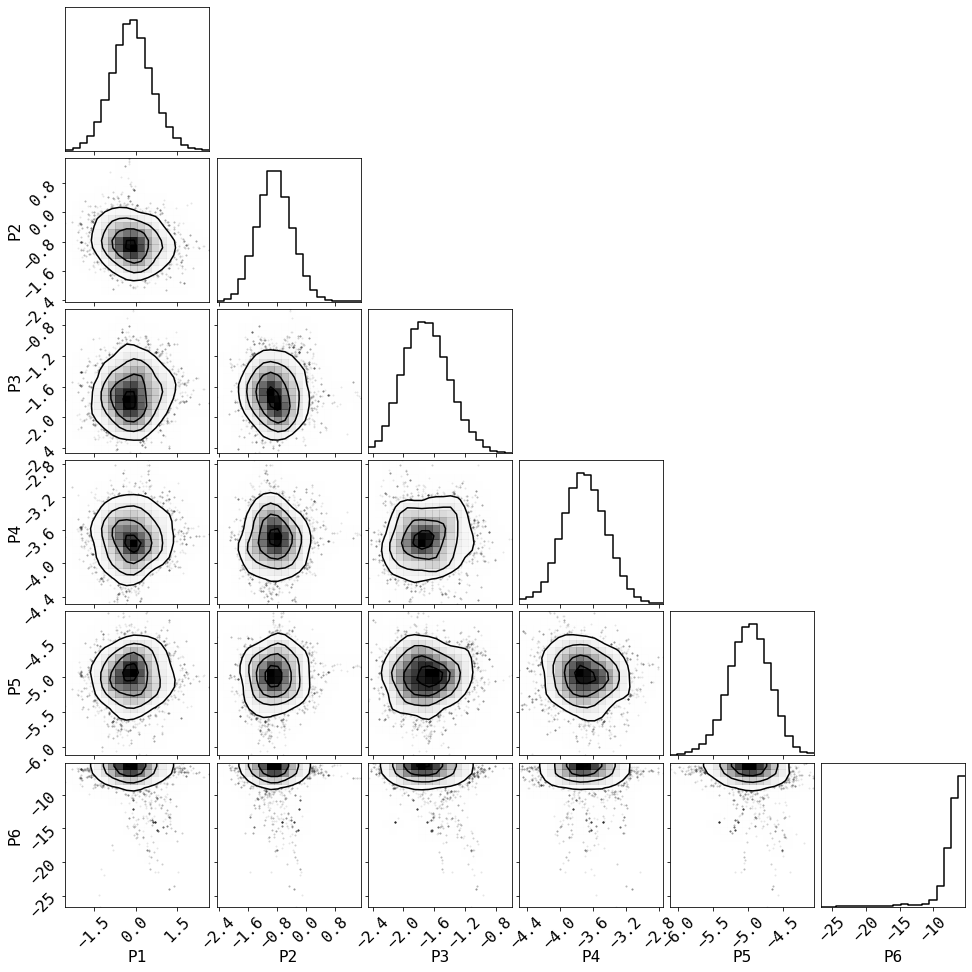

In [21]:
# Summarize the results in a corner plot. Please install corner if not installed
try:
    import corner
    # we use the last half of the chains
    _ = corner.corner(chain[chain.shape[1]//2:,1:-2], smooth=1, smooth1d=1, 
                      labels=['P%d'%i for i in range(1,len(fqBins))])
except ImportError:
    print('Please install corner with "pip install corner"')

---
### Repeat the calculations for the psd of the second light curve

In [12]:
# create the models for individual light curves
psdMods = [fqlag.Psd(timeArrays[i], lc2Arrays[i], lc2Errors[i], fqBins, log=True) for i in range(2)]

# merge the models that calculates the joints likelihood 
psd2Mod = fqlag.multiFqLagBin(psdMods)

# maximize the log-likelihood
psd2, psd2Err, psd2Fit = fqlag.misc.maximize(psd2Mod, inPars)

print('psd values:\t\t', '\t'.join(['%4.4g'%x for x in psd2]))
print('psd uncertainties:\t', '\t'.join(['%4.4g'%x for x in psd2Err]))
print('Maximum Likelihood:\t%4.4g'%(-psd2Fit.fun) )

  -2636.21 |        2.1      0.233      -1.02      -1.88      -3.34      -4.59      -6.38      -8.42 |    6.1e-05
** done **

psd values:		 2.105	0.2331	-1.021	-1.879	-3.34	-4.588	-6.383	-8.417
psd uncertainties:	 0.5927	0.753	0.3745	0.2584	0.2151	0.2294	0.6311	1.992
Maximum Likelihood:	-2636


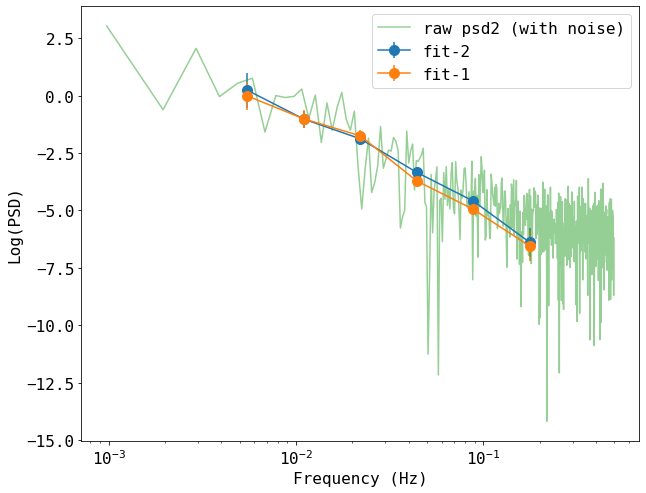

In [13]:
# also plot the result of the second psd

# calcualte the raw psd #
n = data_raw.shape[0]
freq2_raw = np.fft.rfftfreq(n, 1.0)[1:-1]
psd2_raw  = (2*1.0/(n*data_raw[:,3].mean()**2)) * np.abs(np.fft.rfft(data_raw[:,3])[1:-1])**2


plt.figure(figsize=(10,8))
plt.errorbar(freq[1:-1], psd2[1:-1], yerr=psd2Err[1:-1], fmt='-o', ms=10, label='fit-2')
plt.errorbar(freq[1:-1], psd[1:-1], yerr=psdErr[1:-1], fmt='-o', ms=10, label='fit-1')
plt.plot(freq2_raw, np.log(psd2_raw), label='raw psd2 (with noise)', alpha=0.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Log(PSD)')
plt.xscale('log')
plt.legend()

---
### Calculate the cross spectrum and delay

- The PSD values from above will be used as input for the modeling
- The model calculates the *phase* $\phi$ delay not the time delay $\tau$. These are related by: $\tau(f) = \phi(f)/2\pi f$, where $f$ is the frequency at which the delay is measured (i.e. the center of the bin)
- The procedure is similar to the PSD case, but now the model taken both light curves as input. For instance, whereas in the PSD case the time array was given as a single numby array, here, a list that contains the first and the second time arrays should passed to `fqlag.Cxd`.
- Our simulated light curves have an input phase delay of $\phi=1.0$


In [14]:
# create the models for individual light curves
cxdMods = [fqlag.Cxd([timeArrays[i], timeArrays[i]], 
                     [lc1Arrays[i], lc2Arrays[i]], 
                     [lc1Errors[i], lc2Errors[i]], fqBins, psd, psd2, log=True) for i in range(2)]

# merge the models that calculates the joints likelihood 
cxdMod = fqlag.multiFqLagBin(cxdMods)


We define the input parameters similar to before, but now, a number of bins of `nfq`, we have `2*nfq` model parameters, `nfq` for the cross spectral values, and `nfq` for the phase values.|

In [15]:
# initial parameters, start with ones
inCxd = .5*(psd + psd2) - 1
inPars = np.concatenate([inCxd, inCxd*0])

# print the loglikelihood for the input values ##
logLike = cxdMod.loglikelihood(inPars)

print('Input parameters: ', ' '.join(['%4.4g'%x for x in inPars]))
print('Corresponding Log-likelihood: %4.4g'%logLike)

Input parameters:  0.9952 -0.8908 -2.015 -2.815 -4.527 -5.767 -7.467 -9.332    0   -0   -0   -0   -0   -0   -0   -0
Corresponding Log-likelihood: -5247


In [16]:
#cxd, cxdErr, cxdFit = fqlag.misc.maximize(cxdMod, inPars)
cxd, cxdErr, cxdFit = fqlag.misc.maximize_no_grad(cxdMod, inPars)

print('psd values:\t\t', '\t'.join(['%4.4g'%x for x in cxd]))
print('psd uncertainties:\t', '\t'.join(['%4.4g'%x for x in cxdErr]))
print('Maximum Likelihood:\t%4.4g'%(-cxdFit.fun) )

  -5123.48 |       1.89      0.116      -1.03      -1.81       -3.5       -4.7       -6.4      -7.91       1.07       0.98        1.1       1.03          1       1.11      0.737       1.23 
** done **

psd values:		 1.892	0.116	-1.028	-1.807	-3.496	-4.698	-6.398	-7.908	1.071	0.9805	1.097	1.029	1.005	1.114	0.7369	1.232
psd uncertainties:	 0.06168	0.0007981	0.01303	0.0138	0.03877	0.11	0.3746	0.508	0.1077	0.04321	0.06811	0.05515	0.08815	0.1519	0.264	0.385
Maximum Likelihood:	-5123


---
### Plot the result of the delay calculation

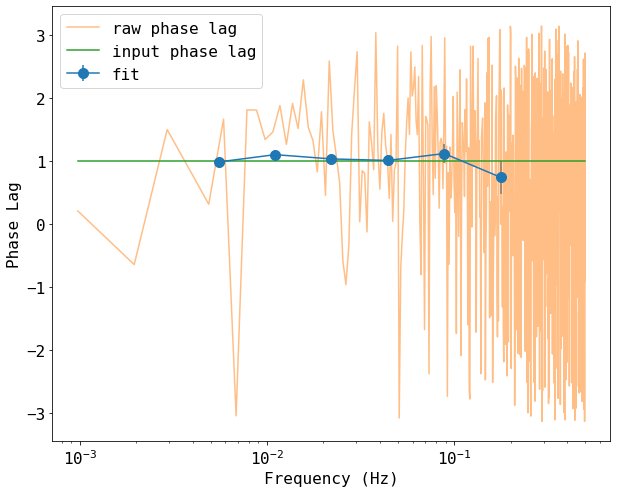

In [19]:
# plot the result of the cross spectrum calculations

# calcualte the raw psd #
n = data_raw.shape[0]
freq_raw = np.fft.rfftfreq(n, 1.0)[1:-1]
phi_raw  = np.angle(np.fft.rfft(data_raw[:,1])[1:-1] * np.conj(np.fft.rfft(data_raw[:,3])[1:-1]))


Cxd, Phi = np.split(cxd, 2)
CxdErr, PhiErr = np.split(cxdErr, 2)

plt.figure(figsize=(10,8))
plt.errorbar(freq[1:-1], Phi[1:-1], yerr=PhiErr[1:-1], fmt='-o', ms=10, label='fit')
plt.plot(freq_raw, phi_raw, label='raw phase lag', alpha=0.5)
plt.plot(freq_raw, freq_raw*0 + 1, label='input phase lag')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase Lag')
plt.xscale('log')
plt.legend()

---
### Run MCMC chain to estimate the posterior distribution
This uses the `emcee` package, similar to the psd case above


In [24]:
cxdChain = fqlag.misc.run_mcmc(cxdMod, cxd, cxdErr, nwalkers=-4, nrun=100)

acceptance fraction:  0.30796875


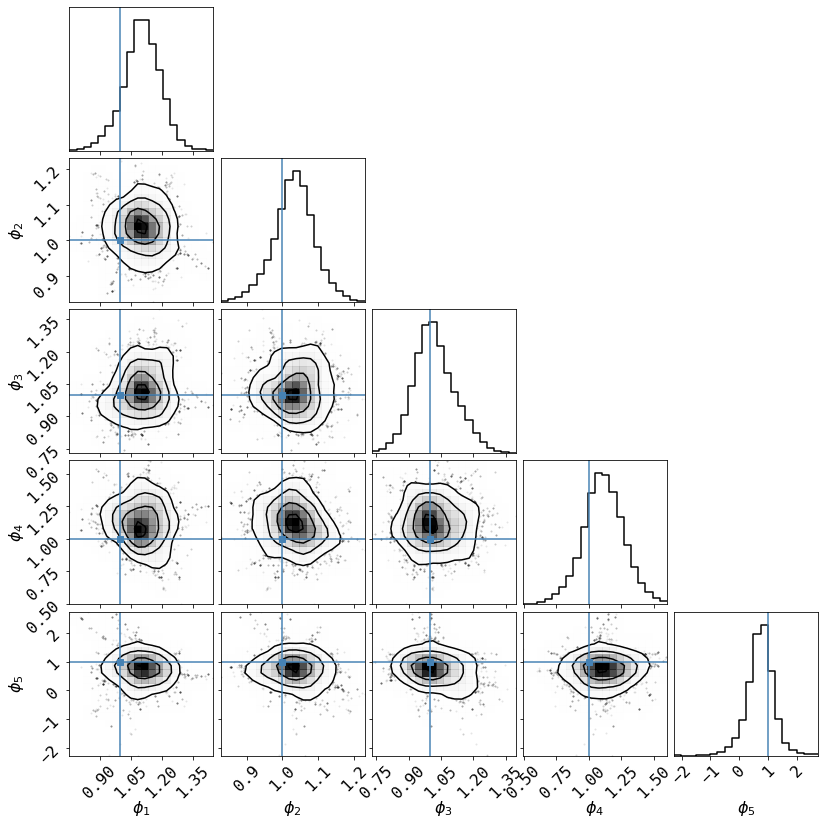

In [28]:
# Summarize the results in a corner plot. Please install corner if not installed
try:
    import corner
    # we use the last half of the chains
    _ = corner.corner(cxdChain[chain.shape[1]//2:,(len(fqBins)+1):-2], smooth=1, smooth1d=1, 
                      labels=['$\phi_%d$'%i for i in range(1,len(fqBins))],
                     truths=np.ones(len(fqBins)-2))
except ImportError:
    print('Please install corner with "pip install corner"')